# Interpretation
This is the final phase that provides a demonstration of the model in action, predicting promotion likelihood for new employees, and extracts the crucial feature importance data, which is vital for providing actionable business insights 
<!-- (e.g., confirming that previous_rating and the engineered performance features are the strongest drivers). -->

In [1]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
final_model = joblib.load("../karim-promotion-ai.joblib")

final_model

,penalty,'l1'
,dual,False
,tol,0.0001
,C,0.1
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


## Random sample generation

In [3]:
def create_new_raw_data(num_samples=1000):
    """Generates a small batch of raw employee data for testing."""
    np.random.seed(42)
    data = {}
    data['age'] = np.random.randint(25, 55, num_samples)
    data['gender'] = np.random.choice(['F', 'M'], num_samples)
    data['department'] = np.random.choice(['Finance', 'HR', 'Operations', 'Sales', 'Technology'], num_samples)
    data['region'] = np.random.choice(['East', 'North', 'South','West'], num_samples)
    data['recruitment_channel'] = np.random.choice(['Agency', 'Direct', 'Referral'], num_samples)
    data['tenure_years'] = np.round(np.random.uniform(1, 15, num_samples), 1)
    data['previous_rating'] = np.random.randint(1, 6, num_samples) 
    data['kpi_met'] = np.clip(np.random.normal(75, 15, num_samples), 0, 100).astype(int)
    data['avg_training_score'] = np.round(np.clip(np.random.normal(85, 8, num_samples), 60, 100), 1)
    data['awards_won'] = np.random.poisson(0.5, num_samples)
    data['trainings_attended'] = np.random.randint(1, 5, num_samples)
    data['education'] = np.random.choice(["Bachelor's", 'High School', "Master's", 'PhD'], num_samples)
    data['work_type'] = np.random.choice(['Full-Time', 'Part-Time Day', 'Part-Time Night'], num_samples)
    data['language_count'] = np.random.choice([1, 2, 3], num_samples)
    data['job_level'] = np.random.randint(1, 6, num_samples)
    data['international_hire'] = np.random.choice([0, 1], num_samples, p=[0.7, 0.3])

    new_raw_df = pd.DataFrame(data)
    return new_raw_df

data = create_new_raw_data()

data.head()

,age,gender,department,region,recruitment_channel,tenure_years,previous_rating,kpi_met,avg_training_score,awards_won,trainings_attended,education,work_type,language_count,job_level,international_hire
0,31,F,Sales,South,Agency,8.7,5,72,87.2,0,1,High School,Full-Time,2,2,1
1,44,F,Finance,East,Agency,14.5,5,70,87.3,0,2,PhD,Part-Time Night,2,4,0
2,53,M,Sales,West,Agency,1.7,2,59,71.5,0,3,PhD,Full-Time,2,1,1
3,39,F,Technology,North,Agency,8.1,4,57,77.2,0,3,PhD,Full-Time,3,5,1
4,35,M,Finance,West,Agency,11.1,4,81,100.0,1,1,High School,Full-Time,2,1,1


### Preprocess the data

In [4]:
def prepare_data_for_model(df_raw):
    df = df_raw.copy()

    # raw columns needed for engineered features
    raw_performance_cols = ['previous_rating', 'avg_training_score', 'kpi_met']
    
    # 1. Weighted Performance Index
    df['weighted_performance_index'] = df[raw_performance_cols].mean(axis=1)

    # 2. High Achiever Flag (Assuming max rating is 5)
    df['high_achiever_flag'] = np.where(
        (df['awards_won'] > 0) & (df['previous_rating'] == 5),
        1,
        0
    )

    # 3. Training Efficiency
    df['training_efficiency'] = df['avg_training_score'] / (df['trainings_attended'] + 1)
    
    # 4. Multilingual Flag (New Feature added in a prior step, assuming language_count >= 2)
    df['multilingual'] = np.where(df['language_count'] >= 2, 1, 0)

    # Features as used in the final model
    num_cols = ['age', 'tenure_years', 'awards_won', 'trainings_attended', 'language_count',
                'weighted_performance_index', 'training_efficiency']
    cat_cols = ['gender', 'department', 'region', 'recruitment_channel', 'work_type',
                'international_hire', 'job_level', 'education'] 
    
    # Simple Imputation (Mocking Phase 1 Imputation)
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())
    df[cat_cols] = df[cat_cols].fillna('missing')
    
    
    # Scaling 
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])
    
    # Label Encoding
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    df[cat_cols] = encoder.fit_transform(df[cat_cols])
    
    df = df.drop(columns=raw_performance_cols + ['avg_training_score'])

    # copied from features at training time
    return df[['age', 'gender', 'department', 'education', 'tenure_years',
       'trainings_attended', 'awards_won', 'job_level', 'region',
       'recruitment_channel', 'work_type', 'language_count', 'multilingual',
       'international_hire', 'weighted_performance_index',
       'high_achiever_flag', 'training_efficiency']]

X = prepare_data_for_model(data)

X.head()

,age,gender,department,education,tenure_years,trainings_attended,awards_won,job_level,region,recruitment_channel,work_type,language_count,multilingual,international_hire,weighted_performance_index,high_achiever_flag,training_efficiency
0,-0.990146,0.0,3.0,1.0,0.203563,-1.345605,-0.697704,1.0,2.0,0.0,0.0,-0.014909,1,1.0,0.191183,0,1.644509
1,0.449663,0.0,0.0,3.0,1.649214,-0.465549,-0.697704,3.0,0.0,0.0,2.0,-0.014909,1,0.0,0.074191,0,0.206274
2,1.446454,1.0,3.0,3.0,-1.541189,0.414506,-0.697704,0.0,3.0,0.0,0.0,-0.014909,1,1.0,-1.760735,0,-0.907117
3,-0.104109,0.0,4.0,3.0,0.054013,0.414506,-0.697704,4.0,1.0,0.0,0.0,1.227489,1,1.0,-1.409759,0,-0.765774
4,-0.547127,1.0,0.0,1.0,0.801763,-1.345605,0.845889,0.0,3.0,0.0,0.0,-0.014909,1,1.0,1.471937,0,2.279316


In [15]:
# confirm that the columns are in the same order as when it was trained
X.columns == ['age', 'gender', 'department', 'education', 'tenure_years',
       'trainings_attended', 'awards_won', 'job_level', 'region',
       'recruitment_channel', 'work_type', 'language_count', 'multilingual',
       'international_hire', 'weighted_performance_index',
       'high_achiever_flag', 'training_efficiency']

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

### Testing model on the genereated dataset

In [16]:
predictions = final_model.predict(X)

# Combine results with employee IDs
results_df = pd.DataFrame({
    'ID': X.index,
    'Predicted_Promotion': predictions
}).set_index('ID')

print(results_df)

     Predicted_Promotion
ID                      
0                      0
1                      0
2                      0
3                      0
4                      1
..                   ...
995                    0
996                    0
997                    0
998                    0
999                    0

[1000 rows x 1 columns]


### Top 10 most influential features

In [21]:
coefficients = final_model.coef_[0]

feature_coefs = pd.Series(coefficients, index=X.columns)

top_10_features = feature_coefs.abs().nlargest(10).index
top_10_coefs = feature_coefs[top_10_features].sort_values(ascending=False)

print("\nTop 10 Most Influential Features (Coefficients):")
print("Magnitude shows importance; Sign shows direction (+ increases promotion likelihood):")
print(top_10_coefs)


Top 10 Most Influential Features (Coefficients):
Magnitude shows importance; Sign shows direction (+ increases promotion likelihood):
weighted_performance_index    0.648179
high_achiever_flag            0.366670
trainings_attended            0.164171
training_efficiency           0.033095
tenure_years                  0.031446
age                           0.031232
region                        0.020958
language_count               -0.031991
recruitment_channel          -0.036691
multilingual                 -0.103342
dtype: float64


### feature coefficients

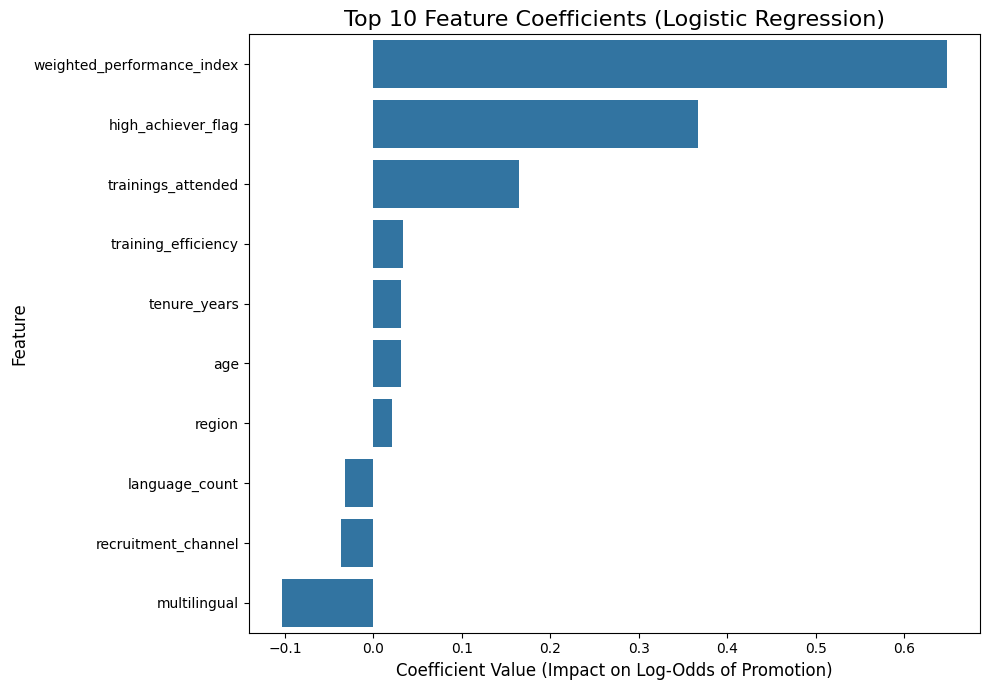

In [23]:
plt.figure(figsize=(10, 7))

sns.barplot(x=top_10_coefs.values, y=top_10_coefs.index)
plt.title('Top 10 Feature Coefficients (Logistic Regression)', fontsize=16)
plt.xlabel('Coefficient Value (Impact on Log-Odds of Promotion)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('../feature_coefficients_lr.png')
plt.show()

### Interpretation Insight

In Logistic Regression, the coefficient represents the change in the log-odds of promotion for a one-unit change in the feature (when all other features are held constant)
1. Positive coefficients (e.g., 'weighted_performance_index', 'high_achiever_flag') strongly increase the probability of promotion.
2. Negative Coefficients (e.g., 'tenure_years') decrease the probability of promotion, potentially signaling career stagnation if tenure increases without a corresponding level jump.
3. The engineered features remain the most influential factors, highlighting the value of feature engineering in this problem.